# Notebook Structure

1. Problem Statement and Data Description
2. Loading Datasets and Libraries
3. Understanding and Validating the Data
4. Data Exploration - Train, Product, Store 

# 1. Problem Statement and Data Description

**Problem Statement:** 
Prevent overstocking and understocking of Items by forecasting demand of items for the next week, based on historical data.




**Data Description:**

Train Data- 
- **WEEK_END_DATE** - week ending date
- **STORE_NUM** - store number
- **UPC** - (Universal Product Code) product specific identifier
- **BASE_PRICE** - base price of item
- **DISPLAY** - product was a part of in-store promotional display
- **FEATURE** - product was in in-store circular
- **UNITS** - units sold (target)

Product Data-
- **UPC** - (Universal Product Code) product specific identifier
- **DESCRIPTION**	- product description
- **MANUFACTURER** - product	manufacturer
- **CATEGORY** - category of product
- **SUB_CATEGORY** - sub-category of product
- **PRODUCT_SIZE** - package size or quantity of product

Store Data-
- **STORE_ID** - store number
- **STORE_NAME** - Name of store
- **ADDRESS_CITY_NAME** - city
- **ADDRESS_STATE_PROV_CODE** - state
- **MSA_CODE** - (Metropolitan Statistical Area) Based on geographic region and population density
- **SEG_VALUE_NAME** - Store Segment Name
- **PARKING_SPACE_QTY** - number of parking spaces in the store parking lot
- **SALES_AREA_SIZE_NUM** - square footage of store
- **AVG_WEEKLY_BASKETS** - average weekly baskets sold in the store

# 2. Loading Required Libraries and Datasets

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context('notebook',font_scale=1.5)

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

We are provided with three tables containing the required information:

- **product_data**: Consists of details about the product
- **store_data**: Consists of details of various stores associated with the retailer  
- **train**: Contains transaction data of products

In [4]:
# reading the data files
train = pd.read_csv('train.csv')
product_data = pd.read_csv('product_data.csv')
store_data = pd.read_csv('store_data.csv')

In [14]:
# checking the size of the dataframes
train.shape, product_data.shape, store_data.shape

((232287, 8), (30, 6), (76, 9))

# 3. Understanding and Validating Data

### Train Data

In [18]:
# printing first 5 rows of the train file
train.head(10)

,WEEK_END_DATE,STORE_NUM,UPC,PRICE,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.39,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,1.98,0,0,35
5,14-Jan-09,367,1111087395,3.36,3.94,0,1,50
6,14-Jan-09,367,1111087396,3.33,4.00,0,1,61
7,14-Jan-09,367,1111087398,3.31,4.00,0,1,72
8,14-Jan-09,367,1600027527,3.19,3.19,0,0,12
9,14-Jan-09,367,1600027528,4.59,4.59,0,0,31


In [17]:
# checking datatypes of columns in train file 
train.dtypes

WEEK_END_DATE     object
STORE_NUM          int64
UPC                int64
PRICE            float64
BASE_PRICE       float64
FEATURE            int64
DISPLAY            int64
UNITS              int64
dtype: object

- WEEK_END_DATE has the data type object, but its a datetime variable 
- The store number and product codes are read as int, but these are categorical variables.

#### Datetime variable 

- The data is captured for what duration?
- What are the start and end dates?
- Is there any missing data points?

#### Numerical Variables

- Check the distribution of numerical variables
- Are there any extreme values?
- Are there any missing values in the variables?

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?


##### WEEK_END_DATE


In [18]:
# convert into the date time format
train['WEEK_END_DATE'] = pd.to_datetime(train['WEEK_END_DATE'])

In [19]:
train['WEEK_END_DATE'].isnull().sum()

0

In [20]:
train['WEEK_END_DATE'].min(), train['WEEK_END_DATE'].max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

- The data collected is from January 2009 to September 2011.

#### Are any dates missing from this period?

In [21]:
(train['WEEK_END_DATE'].max() - train['WEEK_END_DATE'].min())/7

Timedelta('141 days 00:00:00')

In [22]:
train['WEEK_END_DATE'].nunique()

142

- The training data is for 142 weeks, based on the number of unique *weekend dates* in the train file. 
- No dates are missing from this period.

#### Are all dates at a gap of a week?

In [27]:
train['WEEK_END_DATE'].dt.day_name().value_counts()

Wednesday    232287
Name: WEEK_END_DATE, dtype: int64

In [28]:
train['WEEK_END_DATE'].dt.day_name().value_counts()

Wednesday    232287
Name: WEEK_END_DATE, dtype: int64

##### STORE_NUM  and UPC

In [29]:
train[['STORE_NUM', 'UPC']].isnull().sum()

STORE_NUM    0
UPC          0
dtype: int64

In [30]:
train['STORE_NUM'].nunique()

76

In [31]:
(train['STORE_NUM'].value_counts()).sort_values()

8035     1676
23055    1823
2523     1977
11967    2104
15755    2253
         ... 
2277     3824
21237    3950
9825     3955
24991    3967
2513     4098
Name: STORE_NUM, Length: 76, dtype: int64

- We have 76 unique stores.
- Every store has minimum of 1676 transactions.

#### Does each store hold atleast one entry per week?

We have 76 unique stores and 142 weeks of data for the sales. If each store is selling occupies atleast one row in the data, the minimum number of unique rows should be 142*76

In [32]:
142*76

10792

In [33]:
train[['WEEK_END_DATE','STORE_NUM']].drop_duplicates().shape

(10792, 2)

- Implies that each store is atleast selling 1 product each week

In [34]:
train['UPC'].nunique()

30

In [35]:
(train['UPC'].value_counts()).sort_values()

3700044982       975
3700031613      1664
31254742835     2086
7797508004      2386
1111038080      2797
7797508006      2933
31254742735     3202
7218063052      3641
7797502248      6916
1111038078      7131
2840004770      7636
1111009507      8067
1111087396      8131
1111087395      8155
2840004768      8488
7192100336      9126
1111087398      9989
1111009477     10356
1111009497     10498
7192100337     10588
1111085319     10636
3800031829     10640
3800039118     10766
7192100339     10767
1111085350     10775
3800031838     10785
1600027564     10786
1600027528     10788
1111085345     10789
1600027527     10790
Name: UPC, dtype: int64


#### Is every product sold atleast once, for all 142 weeks?

In [36]:
142*30

4260

In [37]:
train[['WEEK_END_DATE','UPC']].drop_duplicates().shape

(4260, 2)

- We have 30 unique products in the training data
- There are 76 different stores associated with the retailer
- Both the variables do not have any missing values

#### Is each store selling each product throughout the given period?

Assuming we have information for the sale of every product that is present in the product table (30), against each store associated (76), and for every week (142); we should have 142*76*30 data rows. 

In [38]:
142*76*30

323760

In [39]:
train.shape

(232287, 8)

In [40]:
232286/323760 

0.7174635532493204

- We can conclude that all stores are not selling all products each week
- Of all the possible combinations, about 72% of the data is present

#### For a store selling a particular product, do we have more than one entry?


Each product sold by any store should hold only one row, i.e. a particular store, say 'store A' selling a product 'prod P' should contribute a single row for every week. Let us check that.

In [41]:
train.shape

(232287, 8)

In [42]:
train[['WEEK_END_DATE','STORE_NUM','UPC']].drop_duplicates().shape

(232287, 3)

In [43]:
train.groupby(['WEEK_END_DATE','STORE_NUM'])['UPC'].count().mean()

21.523999258710155

- The shape does not change after using drop duplicates
- Implies that there are unique combinations for week, store and UPC
- On an average, each week we are selling 22 products

#### Is a store selling a product throughout the period or is there a break?

In [44]:
(train.groupby(['STORE_NUM', 'UPC'])['UNITS'].count()).sort_values()

STORE_NUM  UPC       
4489       1111087396    137
19265      7797508006    137
21221      7797508004    137
6187       1111038080    137
23349      2840004768    137
                        ... 
11993      1111085345    142
           1111085319    142
           1111038080    142
           1600027564    142
29159      7797508004    142
Name: UNITS, Length: 1644, dtype: int64

- Not all stores sell a product throughout the week
- The minimum number is 137/142

We now have a basic understanding of the number of products and stores we are dealing with in this data.

##### BASE_PRICE

In [45]:
train['BASE_PRICE'].isnull().sum()

12

In [46]:
train['BASE_PRICE'].describe()

count    232275.000000
mean          3.345204
std           1.678181
min           0.860000
25%           1.950000
50%           2.990000
75%           4.080000
max           7.890000
Name: BASE_PRICE, dtype: float64

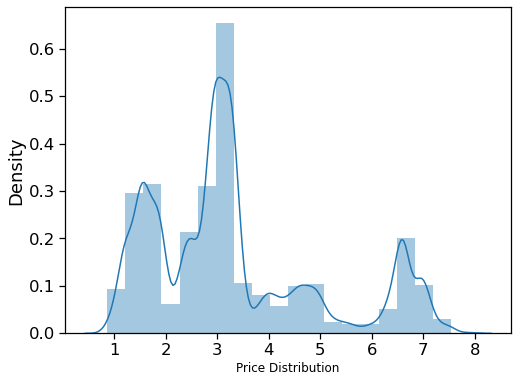

In [47]:
# distribution of Base Price variable
plt.figure(figsize=(8,6))
sns.distplot((train['BASE_PRICE'].values), bins=20, kde=True)
plt.xlabel('Price Distribution', fontsize=12)
plt.show()

- No extreme values in the base price variable
- Range for base price is 1 dollar to 8 dollars

##### FEATURE and DISPLAY

In [48]:
train[['FEATURE','DISPLAY']].isnull().sum()

FEATURE    0
DISPLAY    0
dtype: int64

In [49]:
train[['FEATURE','DISPLAY']].dtypes

FEATURE    int64
DISPLAY    int64
dtype: object

In [50]:
train[['FEATURE','DISPLAY']].nunique()

FEATURE    2
DISPLAY    2
dtype: int64

In [51]:
train['FEATURE'].value_counts(normalize=True)

0    0.900111
1    0.099889
Name: FEATURE, dtype: float64

<Axes: xlabel='FEATURE'>

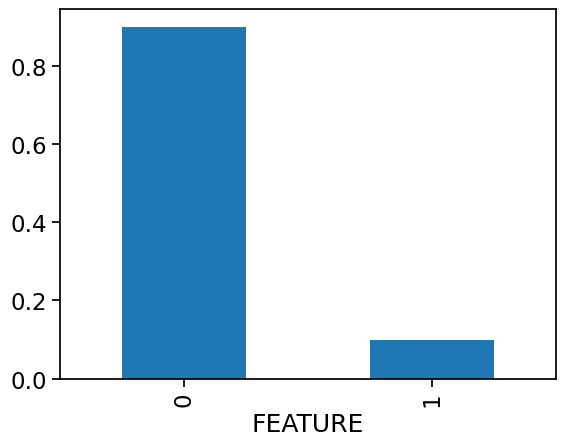

In [23]:
train['FEATURE'].value_counts(normalize=True).plot(kind='bar')

- Approximately 10 percent of product are featured

In [56]:
train['DISPLAY'].value_counts(normalize=True)

0    0.864999
1    0.135001
Name: DISPLAY, dtype: float64

<Axes: xlabel='DISPLAY'>

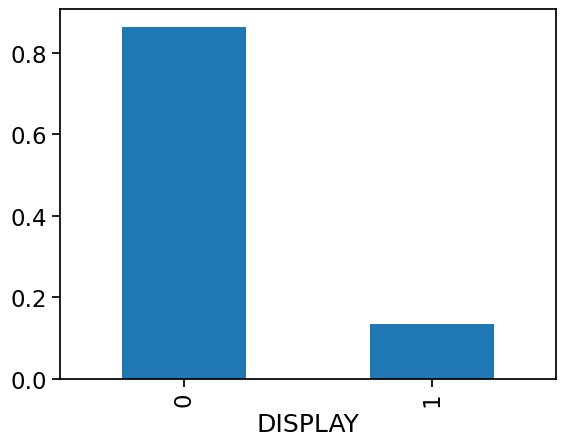

In [12]:
train['DISPLAY'].value_counts(normalize=True).plot(kind='bar')

- About 13% of products are on display

In [58]:
pd.crosstab(train['FEATURE'], train['DISPLAY']).apply(lambda r: r/len(train), axis=1)

DISPLAY,0,1
FEATURE,,
0,0.821824,0.078287
1,0.043175,0.056714


##### UNITS

In [59]:
train['UNITS'].isnull().sum()

0

In [60]:
# basic statistical details of UNITS variable
train['UNITS'].describe()

count    232287.000000
mean         28.063525
std          35.954341
min           0.000000
25%           9.000000
50%          18.000000
75%          34.000000
max        1800.000000
Name: UNITS, dtype: float64

- The Range of values is very high
- Minimum number of units sold is 0 and maximum is 1800
- A huge difference between the 75th percentile and the max value indicates presence of outliers

#### How many rows in the data have 0 units sold?
#### Is there only one row with such high sales of 1800? 

In [61]:
train[train['UNITS'] == 0]

,WEEK_END_DATE,STORE_NUM,UPC,PRICE,BASE_PRICE,FEATURE,DISPLAY,UNITS
76752,2009-12-02,28909,31254742735,NaN,4.99,0,0,0


- Only one entry with 0 items sold
- Indicates the given store does not sell the following item
- It's simply a Data Anomaly and will not be useful in model training

In [62]:
# keeping rows with UNITS sold not equal to zero
train = train[train['UNITS'] != 0]

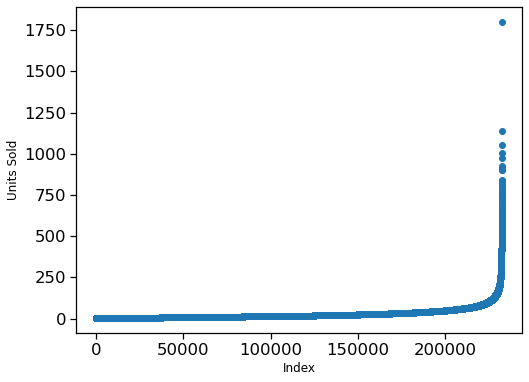

In [63]:
# scatter plot for UNITS variable
plt.figure(figsize=(8,6))
plt.scatter(x = range(train.shape[0]), y = np.sort(train['UNITS'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

- Most of the values are less than 250 
- There are a few outliers (with 1 outlier way outside the range)

In [64]:
train[train['UNITS'] > 1000]

,WEEK_END_DATE,STORE_NUM,UPC,PRICE,BASE_PRICE,FEATURE,DISPLAY,UNITS
7893,2009-02-11,24991,1600027527,1.67,3.19,1,0,1006
7960,2009-02-11,25027,1600027527,1.64,3.19,1,1,1800
9597,2009-02-18,25027,1600027527,1.60,3.19,0,1,1054
11209,2009-02-25,25027,1600027527,1.64,3.19,1,1,1136


To reduce the effect of outliers and for better visualization, here is a log transform of the variable


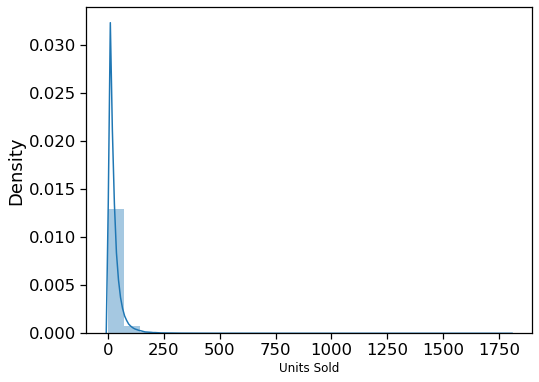

In [65]:
# distribution of UNITS variable
plt.figure(figsize=(8,6))
sns.distplot((train['UNITS'].values), bins=25, kde=True)
plt.xlabel('Units Sold', fontsize=12)
plt.show()

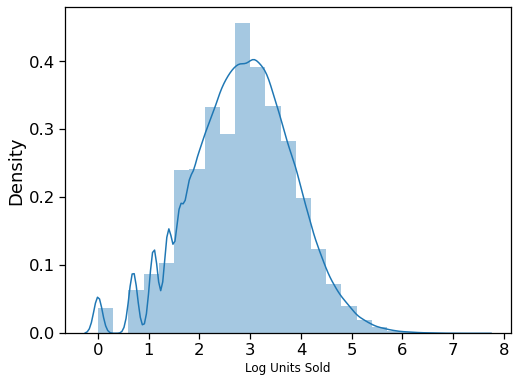

In [66]:
# log transformed UNITS column
plt.figure(figsize=(8,6))
sns.distplot(np.log(train['UNITS'].values), bins=25, kde=True)
plt.xlabel('Log Units Sold', fontsize=12)
plt.show()

- After log transformation, the distribution looks closer to a normal distribution

### Understanding Product Data

In [67]:
# first five rows of product data
product_data.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML
4,1111038080,PL ANTSPTC SPG MNT MTHWS,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [68]:
product_data.dtypes

UPC              int64
DESCRIPTION     object
MANUFACTURER    object
CATEGORY        object
SUB_CATEGORY    object
PRODUCT_SIZE    object
dtype: object

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?

##### UPC 

In [69]:
product_data['UPC'].nunique()

30

- The number is consistent through the train and product data.
##### Are all the product codes exactly the same?

In [70]:
len(set(product_data.UPC).intersection(set(train.UPC)))

30

##### CATEGORY

In [71]:
# number and list of unique categories in the product data
product_data['CATEGORY'].nunique(), product_data['CATEGORY'].unique()

(4,
 array(['BAG SNACKS', 'ORAL HYGIENE PRODUCTS', 'COLD CEREAL',
        'FROZEN PIZZA'], dtype=object))

In [72]:
product_data['CATEGORY'].isnull().sum()

0

In [73]:
product_data['CATEGORY'].value_counts()

COLD CEREAL              9
BAG SNACKS               8
FROZEN PIZZA             7
ORAL HYGIENE PRODUCTS    6
Name: CATEGORY, dtype: int64

- We have four product categories - 
  *  BAG SNACKS
  *  ORAL HYGIENE PRODUCTS 
  *  COLD CEREAL 
  *  FROZEN PIZZA

- There are 9 products with the category 'Cold Cereal'
- Similarly, 8 products labeled 'Bag snacks', 7 with category 'Frozen Pizza' and 6 'Oral Hygiene' Products

#### Is there any subdivision among the product categories?

#####  SUB_CATEGORY 

In [74]:
product_data['SUB_CATEGORY'].isnull().sum()

0

In [75]:
product_data['SUB_CATEGORY'].nunique()

7

In [76]:
# displaying subcategories against each category
product_data[['CATEGORY','SUB_CATEGORY']].drop_duplicates().sort_values(by = 'CATEGORY')

,CATEGORY,SUB_CATEGORY
0,BAG SNACKS,PRETZELS
5,COLD CEREAL,ALL FAMILY CEREAL
6,COLD CEREAL,ADULT CEREAL
19,COLD CEREAL,KIDS CEREAL
8,FROZEN PIZZA,PIZZA/PREMIUM
3,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC)
16,ORAL HYGIENE PRODUCTS,MOUTHWASH/RINSES AND SPRAYS


The sub-categories give additional detail about the product.

- Cereal has 3 sub categories, differentiating on the age group 
- Oral hygiene products have 2 sub categories, antiseptic and rinse/spray
- Bag Snacks & Frozen Pizza have just 1 sub category, no further division


#### Does the sub category has anything to do with the size of the product?

#####  	PRODUCT_SIZE

In [77]:
# unique category, sub-category and product size combinations
product_data[['CATEGORY','SUB_CATEGORY','PRODUCT_SIZE']].drop_duplicates().sort_values(by = 'CATEGORY')

,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,BAG SNACKS,PRETZELS,15 OZ
14,BAG SNACKS,PRETZELS,16 OZ
25,BAG SNACKS,PRETZELS,10 OZ
6,COLD CEREAL,ADULT CEREAL,20 OZ
7,COLD CEREAL,ALL FAMILY CEREAL,18 OZ
19,COLD CEREAL,KIDS CEREAL,15 OZ
20,COLD CEREAL,KIDS CEREAL,12.2 OZ
5,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ
13,COLD CEREAL,ALL FAMILY CEREAL,12 OZ
8,FROZEN PIZZA,PIZZA/PREMIUM,32.7 OZ


The cold cereal for kids is available in two different sizes.
Also, the cold cereal for all family has the same size as the cold cereal for kids.
Hence subcategory is not an indicator of size.

**To summarize**
- Bag Snacks has 1 sub category and 3 product size available
- Oral Hygiene product has 2 sub categories and 2 size options
- Frozen Pizza has only 1 sub category and 6 different package size
- cold ceral has 3 sub categoeies, and 6 options in size

##### DESCRIPTION 

In [78]:
product_data['DESCRIPTION'].isnull().sum()

0

In [79]:
# number and list of unique descriptions in the prodcut data
product_data['DESCRIPTION'].nunique(), product_data['DESCRIPTION'].unique()

(29,
 array(['PL MINI TWIST PRETZELS', 'PL PRETZEL STICKS', 'PL TWIST PRETZELS',
        'PL BL MINT ANTSPTC RINSE', 'PL ANTSPTC SPG MNT MTHWS',
        'PL HONEY NUT TOASTD OATS', 'PL RAISIN BRAN',
        'PL BT SZ FRSTD SHRD WHT', 'PL SR CRUST SUPRM PIZZA',
        'PL SR CRUST 3 MEAT PIZZA', 'PL SR CRUST PEPPRN PIZZA',
        'GM HONEY NUT CHEERIOS', 'GM CHEERIOS', 'RLDGLD TINY TWISTS PRTZL',
        'RLDGLD PRETZEL STICKS', 'SCOPE ORIG MINT MOUTHWASH',
        'CREST PH CLN MINT RINSE', 'KELL BITE SIZE MINI WHEAT',
        'KELL FROSTED FLAKES', 'KELL FROOT LOOPS', 'DIGIORNO THREE MEAT',
        'DIGRN SUPREME PIZZA', 'DIGRN PEPP PIZZA',
        'FRSC BRCK OVN ITL PEP PZ', 'SNYDR PRETZEL RODS',
        'SNYDR SOURDOUGH NIBBLERS', 'SNYDR FF MINI PRETZELS',
        'LSTRNE CL MINT ANTSPTC MW', 'LSTRNE FRS BRST ANTSPC MW'],
       dtype=object))

- We have 29 descriptions in the dataset, for 30 products.
- Almost all products have a unique description. 

In [80]:
(product_data['DESCRIPTION'].value_counts())

GM CHEERIOS                  2
PL MINI TWIST PRETZELS       1
SCOPE ORIG MINT MOUTHWASH    1
LSTRNE CL MINT ANTSPTC MW    1
SNYDR FF MINI PRETZELS       1
SNYDR SOURDOUGH NIBBLERS     1
SNYDR PRETZEL RODS           1
FRSC BRCK OVN ITL PEP PZ     1
DIGRN PEPP PIZZA             1
DIGRN SUPREME PIZZA          1
DIGIORNO THREE MEAT          1
KELL FROOT LOOPS             1
KELL FROSTED FLAKES          1
KELL BITE SIZE MINI WHEAT    1
CREST PH CLN MINT RINSE      1
RLDGLD PRETZEL STICKS        1
PL PRETZEL STICKS            1
RLDGLD TINY TWISTS PRTZL     1
GM HONEY NUT CHEERIOS        1
PL SR CRUST PEPPRN PIZZA     1
PL SR CRUST 3 MEAT PIZZA     1
PL SR CRUST SUPRM PIZZA      1
PL BT SZ FRSTD SHRD WHT      1
PL RAISIN BRAN               1
PL HONEY NUT TOASTD OATS     1
PL ANTSPTC SPG MNT MTHWS     1
PL BL MINT ANTSPTC RINSE     1
PL TWIST PRETZELS            1
LSTRNE FRS BRST ANTSPC MW    1
Name: DESCRIPTION, dtype: int64

In [81]:
product_data.loc[product_data['DESCRIPTION']=='GM CHEERIOS']

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
12,1600027528,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,18 OZ
13,1600027564,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ


In [82]:
product_data.loc[product_data['UPC'] == 1600027527]

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
11,1600027527,GM HONEY NUT CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ


- More granular description for the product
- Includes the type of product and manufacturer

##### MANUFACTURER


#### How many Manufacturers/ suppliers are we associated with?

#### Are same products created by multiple manufacturers?


In [83]:
product_data['MANUFACTURER'].isnull().sum()

0

In [84]:
product_data['MANUFACTURER'].nunique()

9

In [85]:
# displaying the list of manufacturers against the 4 categories
temp = product_data[['CATEGORY','MANUFACTURER']].drop_duplicates()
pd.crosstab([temp['CATEGORY']], temp['MANUFACTURER'])

MANUFACTURER,FRITO LAY,GENERAL MI,KELLOGG,P & G,PRIVATE LABEL,SNYDER S,TOMBSTONE,TONYS,WARNER
CATEGORY,,,,,,,,,
BAG SNACKS,1,0,0,0,1,1,0,0,0
COLD CEREAL,0,1,1,0,1,0,0,0,0
FROZEN PIZZA,0,0,0,0,1,0,1,1,0
ORAL HYGIENE PRODUCTS,0,0,0,1,1,0,0,0,1


- We have 4 unique categories of Products
- Each category has three manufacturers
- Every category has a manufacturer 'private label' (and 2 other manufacturers)

### Understanding Store Data

In [86]:
store_data.head()

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
1,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24767
2,613,EAST ALLEN,ALLEN,TX,19100,MAINSTREAM,464.0,64926,29386
3,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36741
4,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54053


In [87]:
store_data.dtypes

STORE_ID                     int64
STORE_NAME                  object
ADDRESS_CITY_NAME           object
ADDRESS_STATE_PROV_CODE     object
MSA_CODE                     int64
SEG_VALUE_NAME              object
PARKING_SPACE_QTY          float64
SALES_AREA_SIZE_NUM          int64
AVG_WEEKLY_BASKETS           int64
dtype: object

#### Numerical Variables

- Check the distribution of numerical variables
- Are there any extreme values?
- Are there any missing values in the variables?

#### Categorical Variables

- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?

##### STORE_ID

In [88]:
store_data['STORE_ID'].nunique()

76

In [89]:
len(set(store_data.STORE_ID).intersection(set(train.STORE_NUM)))

76

##### STORE_NAME

In [90]:
store_data['STORE_NAME'].isnull().sum()

0

In [91]:
store_data['STORE_NAME'].nunique()

72

- The number of unique store IDs is more than number of unique store names
- There might be stores with same name, located in different city

#### Which store name is being repeated?

#### Why do some stores have same name and different ID?

In [92]:
# number of store names repeating
store_data['STORE_NAME'].value_counts()

HOUSTON            4
MIDDLETOWN         2
15TH & MADISON     1
DUNCANVILLE        1
WOOD FOREST S/C    1
                  ..
AT EASTEX FRWY     1
DENT               1
THE WOODLANDS      1
LANDEN             1
CARROLLTON         1
Name: STORE_NAME, Length: 72, dtype: int64

In [93]:
store_data.loc[store_data['STORE_NAME'] == 'HOUSTON']

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
3,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36741
9,2513,HOUSTON,HOUSTON,TX,26420,UPSCALE,NaN,61833,32423
54,21485,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472
59,23327,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,50722,30258


In [94]:
store_data.loc[store_data['STORE_NAME'] == 'MIDDLETOWN']

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
50,21221,MIDDLETOWN,MIDDLETOWN,OH,17140,VALUE,NaN,48128,17010
74,28909,MIDDLETOWN,MIDDLETOWN,OH,17140,MAINSTREAM,NaN,85876,28986


The store names that are repeated, are actually different stores which either have a different city or different segment (upscale, mainstream, value) or  location. Hence they are given a different IDs. 

##### ADDRESS_CITY_NAME  and ADDRESS_STATE_PROV_CODE

In [95]:
store_data[['ADDRESS_STATE_PROV_CODE', 'ADDRESS_CITY_NAME']].isnull().sum()

ADDRESS_STATE_PROV_CODE    0
ADDRESS_CITY_NAME          0
dtype: int64

#### How many cities and states are the stores located in?

In [96]:
store_data[['ADDRESS_STATE_PROV_CODE', 'ADDRESS_CITY_NAME']].nunique()

ADDRESS_STATE_PROV_CODE     4
ADDRESS_CITY_NAME          51
dtype: int64

<img src = 'texas-to-ohio-map-map-of-arizona-and-california-cities-california-map-major-cities-of-texas-to-ohio-map.jpg' width = 700 height = 700>

Let's find out the number of stores in each of the state 

In [97]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count()

ADDRESS_STATE_PROV_CODE
IN     1
KY     4
OH    30
TX    41
Name: STORE_ID, dtype: int64

- Each store has a unique store ID 
- Most stores are from Ohio and Texas ~93%
- Few from Kentucky and Indiana ~7%

In [98]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['ADDRESS_CITY_NAME'].nunique()

ADDRESS_STATE_PROV_CODE
IN     1
KY     3
OH    16
TX    31
Name: ADDRESS_CITY_NAME, dtype: int64

In [99]:
store_data['ADDRESS_CITY_NAME'].value_counts()

CINCINNATI         9
HOUSTON            8
MIDDLETOWN         3
COVINGTON          2
SUGAR LAND         2
LOVELAND           2
MAINEVILLE         2
HAMILTON           2
KATY               2
MCKINNEY           2
DAYTON             2
CROWLEY            1
GOSHEN             1
PASADENA           1
WOODLANDS          1
MESQUITE           1
SPRINGFIELD        1
FLOWER MOUND       1
SOUTHLAKE          1
FRISCO             1
WEST CHESTER       1
DENTON             1
CYPRESS            1
LEBANON            1
RICHARDSON         1
GARLAND            1
KETTERING          1
DUNCANVILLE        1
VANDALIA           1
MAGNOLIA           1
BEAUMONT           1
ALLEN              1
MILFORD            1
BLUE ASH           1
CLUTE              1
DICKINSON          1
GRAND PRAIRIE      1
ARLINGTON          1
LAWRENCEBURG       1
ROCKWALL           1
COLLEGE STATION    1
MASON              1
SAINT MARYS        1
KINGWOOD           1
BAYTOWN            1
THE WOODLANDS      1
INDEPENDENCE       1
DALLAS       

##### MSA_CODE

In [100]:
store_data['MSA_CODE'].isnull().sum()

0

In [101]:
store_data['MSA_CODE'].nunique(), store_data['MSA_CODE'].unique()

(9, array([17140, 19100, 26420, 17780, 47540, 43300, 19380, 13140, 44220]))

In [102]:
store_data['MSA_CODE'].value_counts()

17140    29
26420    21
19100    17
19380     4
17780     1
47540     1
43300     1
13140     1
44220     1
Name: MSA_CODE, dtype: int64

In [103]:
(store_data.groupby(['MSA_CODE', 'ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count())

MSA_CODE  ADDRESS_STATE_PROV_CODE
13140     TX                          1
17140     IN                          1
          KY                          4
          OH                         24
17780     TX                          1
19100     TX                         17
19380     OH                          4
26420     TX                         21
43300     TX                          1
44220     OH                          1
47540     OH                          1
Name: STORE_ID, dtype: int64

- These codes are assigned based on the geographical location and population density. 
- 17140 is present in all three except Texas (which has a different geographical region)

##### PARKING_SPACE_QTY  and SALES_AREA_SIZE_NUM 

In [104]:
store_data[['PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']].isnull().sum()

PARKING_SPACE_QTY      51
SALES_AREA_SIZE_NUM     0
dtype: int64

- Of 76 stores, parking area of 51 is missing

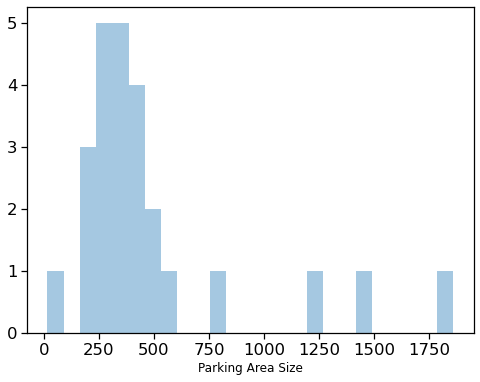

In [105]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['PARKING_SPACE_QTY'], bins=25, kde=False)
plt.xlabel('Parking Area Size', fontsize=12)
plt.show()

- About 15 stores have parking area between 250 - 500 units

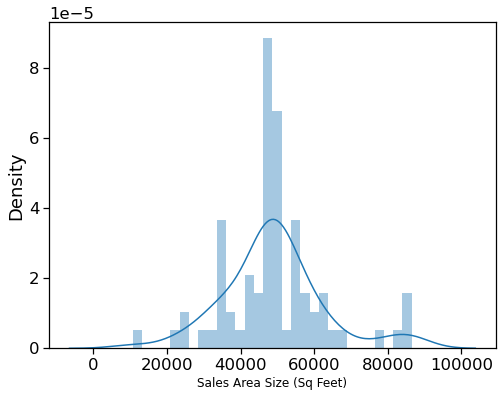

In [106]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['SALES_AREA_SIZE_NUM'], bins=30, kde=True)
plt.xlabel('Sales Area Size (Sq Feet)', fontsize=12)
plt.show()

- Most stores have the area between 30-70 K
- Only a small number of stores have area less than 30k or greater than 90k

#### How is Average store size varying for different states?

In [107]:
(store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['SALES_AREA_SIZE_NUM'].mean()).sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
IN    58563.000000
OH    52691.200000
TX    46920.902439
KY    39855.500000
Name: SALES_AREA_SIZE_NUM, dtype: float64

<AxesSubplot:xlabel='SALES_AREA_SIZE_NUM', ylabel='Density'>

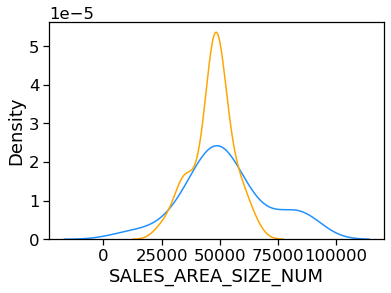

In [108]:
state_oh = store_data.loc[store_data['ADDRESS_STATE_PROV_CODE'] == 'OH']
state_tx = store_data.loc[store_data['ADDRESS_STATE_PROV_CODE'] == 'TX']

sns.distplot(state_oh['SALES_AREA_SIZE_NUM'], hist=False,color= 'dodgerblue', label= 'OHIO')
sns.distplot(state_tx['SALES_AREA_SIZE_NUM'], hist=False,  color= 'orange', label= 'TEXAS')


- Indiana has only one store and the area size is 58,563 sq feet. 
- Ohio and Texas have average around 52k and 50k. 
- Ohio has stores distributed at all sizes.
- Texas mainly has stores between sales area 30k to 60k 

##### AVG_WEEKLY_BASKETS

In [109]:
store_data['AVG_WEEKLY_BASKETS'].isnull().sum()

0

In [110]:
store_data['AVG_WEEKLY_BASKETS'].describe()

count       76.000000
mean     24226.921053
std       8863.939362
min      10435.000000
25%      16983.500000
50%      24667.500000
75%      29398.500000
max      54053.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

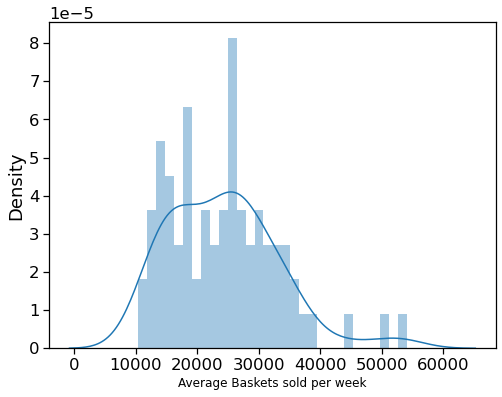

In [111]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['AVG_WEEKLY_BASKETS'], bins=30, kde=True)
plt.xlabel('Average Baskets sold per week', fontsize=12)
plt.show()

#### What are the average weekly baskets sold for the states? 

In [112]:
(store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['AVG_WEEKLY_BASKETS'].mean()).sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
OH    26113.766667
TX    23234.195122
KY    21489.000000
IN    19275.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

##### SEG_VALUE_NAME

In [113]:
store_data['SEG_VALUE_NAME'].isnull().sum()

0

There are certain segments assigned to store, based on the brand and quality of products sold at the store.

- **Upscale stores** : Located in high income neighborhoods and offer more high-end product
- **Mainstream stores** : Located in middle class areas, offering a mix of upscale and value product
- **Value stores** : Focus on low prices products targeting low income customers

Let us look at the distribution of stores in each of these segments

In [114]:
store_data['SEG_VALUE_NAME'].value_counts()

MAINSTREAM    43
VALUE         19
UPSCALE       14
Name: SEG_VALUE_NAME, dtype: int64

#### Does the segment has any relation with the store area?

#### Is there a difference in the average sales for each segment?

In [115]:
(store_data.groupby(['SEG_VALUE_NAME'])['SALES_AREA_SIZE_NUM'].mean()).sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       59556.428571
MAINSTREAM    50075.976744
VALUE         38706.368421
Name: SALES_AREA_SIZE_NUM, dtype: float64

In [116]:
(store_data.groupby(['SEG_VALUE_NAME'])['AVG_WEEKLY_BASKETS'].mean()).sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       28735.928571
MAINSTREAM    24024.093023
VALUE         21363.526316
Name: AVG_WEEKLY_BASKETS, dtype: float64